In [1]:
import numpy as np
import warnings
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
wine = pd.read_csv("~/ucare-summer2020/datasets/winequality-white.csv", sep=";")

In [3]:
X = wine.drop(columns=['quality'])
y = wine['quality']
y = y > 5
y = y.astype(int)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [17]:
def polynomial_report(feature1, feature2):
    eff_X = X.loc[:, [feature1, feature2]]
    eff_X_test = X_test.loc[:, [feature1, feature2]]
    eff_X_train = X_train.loc[:, [feature1, feature2]]

    eff_X_train_poly = poly_features.fit_transform(eff_X_train)
    eff_X_test_poly = poly_features.fit_transform(eff_X_test)
    
    param_grid = {'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
             'tol': [1e-3, 1e-4, 1e-5], 'max_iter': [3000, 5000, 10000, 20000],
             'C': [0.0001, 0.001, 0.1, 0.5, 1, 10]}
    lg_reg = LogisticRegression()
    lg_reg_cv = GridSearchCV(lg_reg, param_grid, scoring='accuracy',
                            cv=3, verbose=1, n_jobs=-1)
    lg_reg_cv.fit(eff_X_train_poly, y_train)
    params_optimal = lg_reg_cv.best_params_

    print("Optimal Hyperparameter Values: ", params_optimal)
    print("\n")
    
    lg_reg_clf = LogisticRegression(**params_optimal)
    lg_reg_clf.fit(eff_X_train_poly, y_train)
    
    plot_boundary_clf(lg_reg_clf, eff_X)
    
    y_train_predicted = lg_reg_clf.predict(eff_X_train_poly)
    y_test_predicted = lg_reg_clf.predict(eff_X_test_poly)
    print("\nTrain Accuracy: ", np.mean(y_train_predicted == y_train))
    
    print("-----------------------------------------")
    print("\nTest Accuracy: ", np.mean(y_test_predicted == y_test))
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_predicted))


    precision_test = precision_score(y_test, y_test_predicted) 
    print("\nTest Precision = %f" % precision_test)

    recall_test = recall_score(y_test, y_test_predicted)
    print("Test Recall = %f" % recall_test)


    f1_test = f1_score(y_test, y_test_predicted)
    print("Test F1 Score = %f" % f1_test)


    print("\nClassification Report:")
    print(classification_report(y_test, y_test_predicted))

In [6]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X.iloc[:,0].min() - 0.1, X.iloc[:, 0].max() + 0.1
    
    # Get the min and max value of feature x2
    x2min, x2max = X.iloc[:,1].min() - 0.1, X.iloc[:, 1].max() + 0.1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    X_new_poly = poly_features.fit_transform(X_new)
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new_poly).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.binary, alpha=0.8)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new_poly).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()

In [23]:
def plot_boundary_clf(clf, X):
    plt.figure(figsize=(12, 6))
    
    decision_boundary_class_colored(clf, X)

    plt.plot(X[y==0].iloc[:,0], X[y==0].iloc[:,1], "bs", ms=3)
    plt.plot(X[y==1].iloc[:,0], X[y==1].iloc[:,1], "g^", ms=3)
    
    xmin, xmax = X.min() - 0.01, X.max() + 0.01
    plt.axis([xmin[0], xmax[0], xmin[1], xmax[1]])
    plt.annotate('Bad Wine', xy=(0.85, 0.95), xycoords='axes fraction', color="b")
    plt.annotate('Good Wine', xy=(0.85, 0.85), xycoords='axes fraction', color="g")
    plt.xlabel("Feature 1", fontsize=14)
    plt.ylabel("Feature 2", fontsize=14)
    plt.title("Polynomial Features Plot", fontsize=16)
    plt.show()

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.2min finished


Optimal Hyperparameter Values:  {'C': 1, 'max_iter': 3000, 'solver': 'liblinear', 'tol': 1e-05}




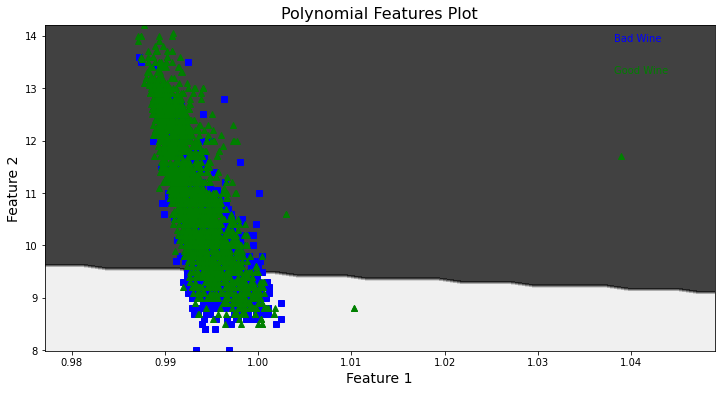


Train Accuracy:  0.6949974476773865
-----------------------------------------

Test Accuracy:  0.6969387755102041

Test Confusion Matrix:
[[138 183]
 [114 545]]

Test Precision = 0.748626
Test Recall = 0.827011
Test F1 Score = 0.785869

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.43      0.48       321
           1       0.75      0.83      0.79       659

    accuracy                           0.70       980
   macro avg       0.65      0.63      0.63       980
weighted avg       0.68      0.70      0.69       980



In [14]:
polynomial_report("density", "alcohol")

In [19]:
poly_features = PolynomialFeatures(degree=5, include_bias=False)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 12.7min finished


Optimal Hyperparameter Values:  {'C': 0.0001, 'max_iter': 3000, 'solver': 'liblinear', 'tol': 1e-05}




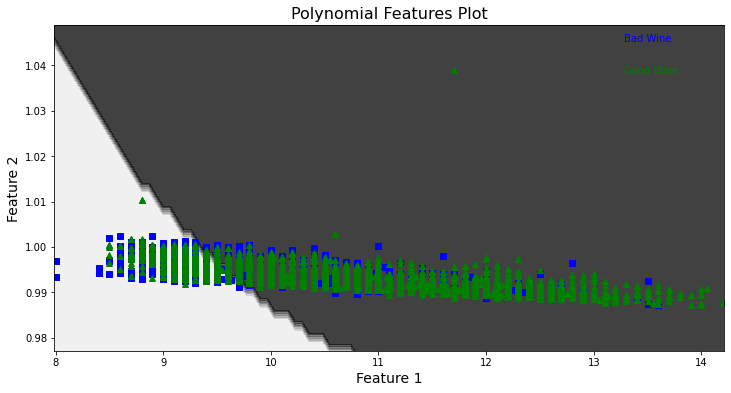


Train Accuracy:  0.6975497702909648
-----------------------------------------

Test Accuracy:  0.7

Test Confusion Matrix:
[[150 171]
 [123 536]]

Test Precision = 0.758133
Test Recall = 0.813354
Test F1 Score = 0.784773

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.47      0.51       321
           1       0.76      0.81      0.78       659

    accuracy                           0.70       980
   macro avg       0.65      0.64      0.64       980
weighted avg       0.69      0.70      0.69       980



In [20]:
polynomial_report("alcohol", "density")

In [21]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  6.5min finished


Optimal Hyperparameter Values:  {'C': 0.5, 'max_iter': 3000, 'solver': 'liblinear', 'tol': 1e-05}




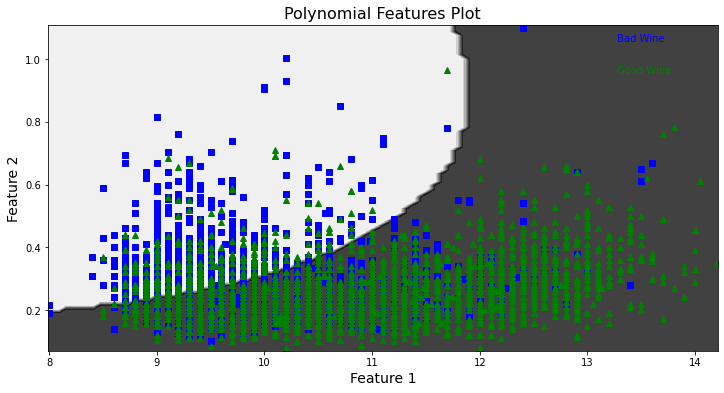


Train Accuracy:  0.7516590096988259
-----------------------------------------

Test Accuracy:  0.7428571428571429

Test Confusion Matrix:
[[150 171]
 [ 81 578]]

Test Precision = 0.771696
Test Recall = 0.877086
Test F1 Score = 0.821023

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.47      0.54       321
           1       0.77      0.88      0.82       659

    accuracy                           0.74       980
   macro avg       0.71      0.67      0.68       980
weighted avg       0.73      0.74      0.73       980



In [22]:
polynomial_report("alcohol", "volatile acidity")